# Random Fourier Features for Scalable Kernels


[Random Features for Large-Scale Kernel Machines](https://proceedings.neurips.cc/paper/2007/file/013a006f03dbc5392effeb8f18fda755-Paper.pdf) by Ali Rahimi and Benjamin Recht.

[`sklearn.metrics.pairwise.rbf_kernel`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.datasets import make_s_curve


N = 1000
D = 3
X, t = make_s_curve(N, noise=0.1)

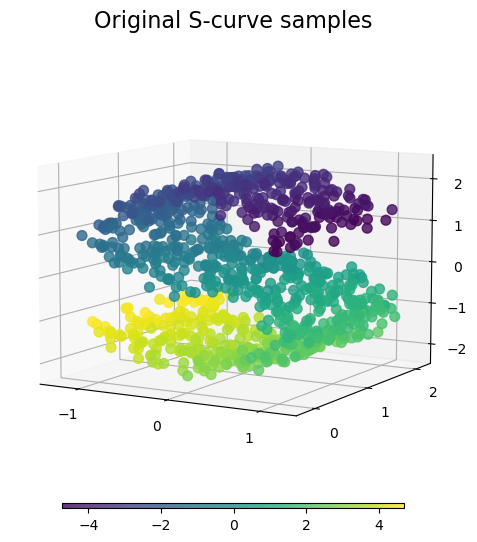

In [10]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(figsize=(6, 6), facecolor="white", tight_layout=True, subplot_kw={"projection": "3d"})
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()

plot_3d(X, t, "Original S-curve samples")

In [11]:
X = X[t.argsort()]

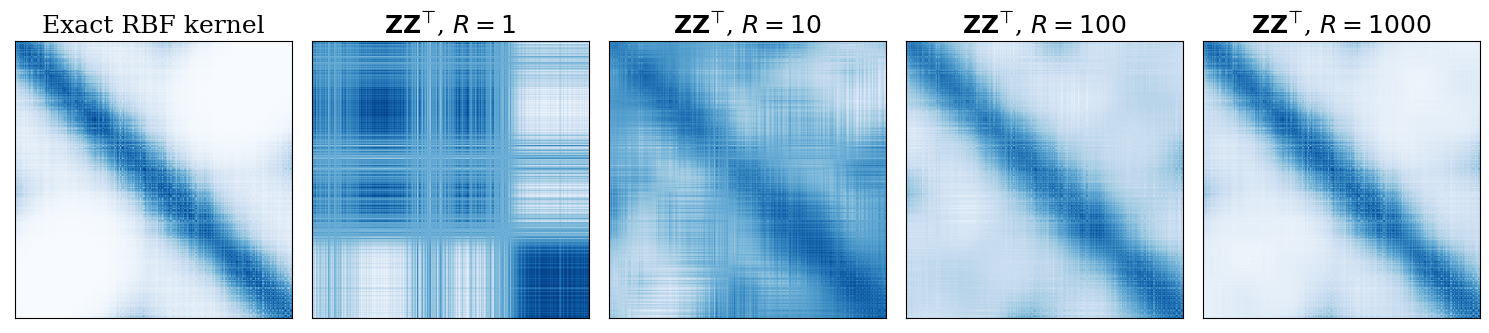

In [12]:
fig, axes = plt.subplots(1, 5)
fig.set_size_inches(15, 4)
font = {'fontname': 'serif', 'fontsize': 18}

gamma = 1/2.
# The RBF kernel is the Gaussian kernel.
K = rbf_kernel(X, gamma=gamma)

axes[0].imshow(K, cmap=plt.cm.Blues)
axes[0].set_title('Exact RBF kernel', **font)
axes[0].set_xticks([])
axes[0].set_yticks([])

sigma = 1.

for R, ax in zip([1, 10, 100, 1000], axes[1:]):
    W    = np.random.normal(loc=0, scale=1, size=(R, D))
    B    = np.random.uniform(0, 2*np.pi, size=(R,1))
    norm = 1./ np.sqrt(R)
    Z    = norm * np.sqrt(2) * np.cos(sigma*W @ X.T + B)
    ZZ   = Z.T@Z

    ax.imshow(ZZ, cmap=plt.cm.Blues)
    ax.set_title(r'$\mathbf{Z} \mathbf{Z}^{\top}$, $R=%s$' % R, **font)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Radial basis function kernel [`RBF`](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html)

In [14]:
from   sklearn.gaussian_process.kernels import RBF

N     = 100
X     = np.linspace(-10, 10, 2*N)[:, None]

mean  = np.zeros(X.shape[0])
cov   = RBF()(X)
y_true = np.random.multivariate_normal(mean, cov)

noise = np.random.normal(0, 0.5, 2*N)
y    = y_true + noise

X_train =  X[::2]#[:, None]
y_train = y[::2]#[:, None]

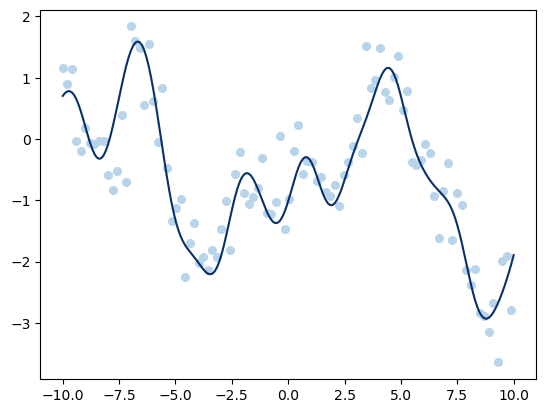

In [15]:
cmap      = plt.cm.get_cmap('Blues')
plt.plot(X, y_true, c=cmap(1.))
plt.scatter(X_train, y_train, s=30, c=[cmap(0.3)])
plt.show()

[`KernelRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

In [31]:
from   sklearn.kernel_ridge import KernelRidge

kkr = KernelRidge(kernel="rbf")
kkr.fit(X_train, y_train)

y_pred = kkr.predict(X)

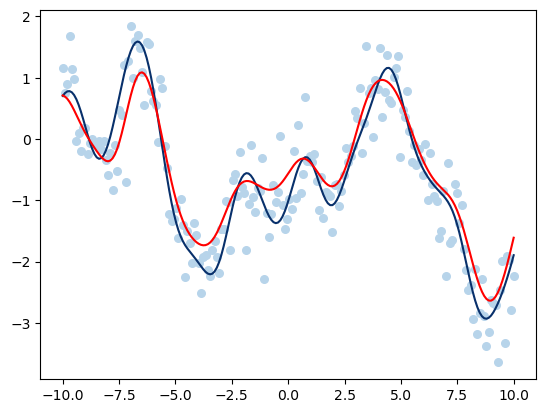

In [32]:
cmap      = plt.cm.get_cmap('Blues')
plt.plot(X, y_true, c=cmap(1.))
plt.scatter(X, y, s=30, c=[cmap(0.3)])
plt.plot(X, y_pred, c='red')
plt.show()

[`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [44]:
from   sklearn.linear_model import Ridge
from   sklearn.exceptions import NotFittedError

class RFFRidgeRegression:

    def __init__(self, rff_dim=1, alpha=1.0, sigma=1.0):
        """Kernel ridge regression using random Fourier features.
        rff_dim : Dimension of random feature.
        alpha :   Regularization strength. Should be a positive float.
        """
        self.fitted  = False
        self.rff_dim = rff_dim
        self.sigma   = sigma
        self.lm      = Ridge(alpha=alpha)
        self.B_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
        Z = self._get_rffs(X)
        self.lm.fit(Z.T, y)
        self.fitted = True
        pass

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if not self.fitted:
            msg = "Call 'fit' with appropriate arguments first."
            raise NotFittedError(msg)
        Z = self._get_rffs(X)
        return self.lm.predict(Z.T)

    def _get_rffs(self, X):
        """Return random Fourier features based on data X, as well as random
        variables W and b.
        """
        if self.W_ is None and self.B_ is None:
            self.W_    = np.random.normal(loc=0, scale=1, size=(self.rff_dim, X.shape[1]))
            self.B_    = np.random.uniform(0, 2*np.pi, size=(self.rff_dim,1))
        norm = 1./ np.sqrt(self.rff_dim)
        Z    = norm * np.sqrt(2) * np.cos(self.sigma*self.W_ @ X.T + self.B_)
        return Z

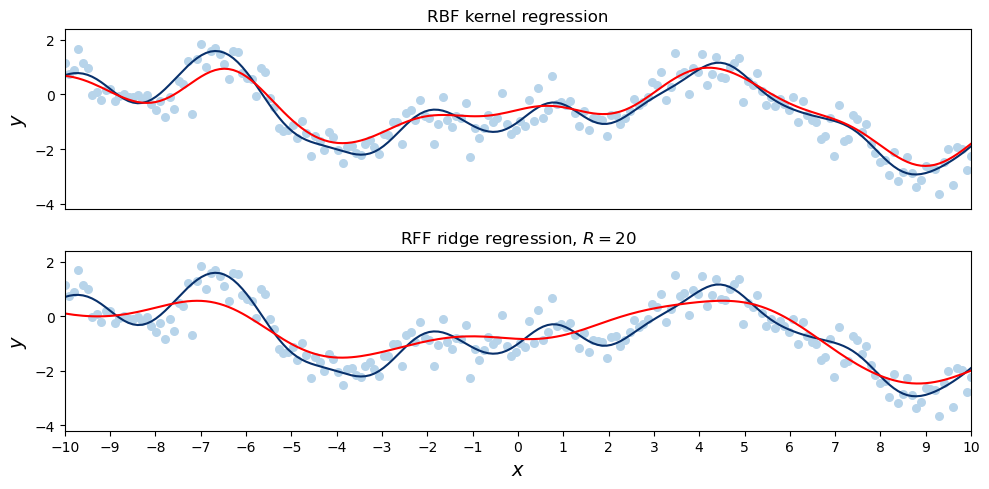

In [45]:
# Set up figure and plot data.
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(10, 5)
ax1, ax2  = axes
cmap      = plt.cm.get_cmap('Blues')

ax1.scatter(X, y, s=30, c=[cmap(0.3)])
ax2.scatter(X, y, s=30, c=[cmap(0.3)])
ax1.plot(X, y_true, c=cmap(1.))
ax2.plot(X, y_true, c=cmap(1.))

# Fit kernel ridge regression using an RBF kernel.
clf    = KernelRidge(kernel=RBF())
clf    = clf.fit(X_train, y_train)
y_pred = clf.predict(X)
ax1.plot(X, y_pred, c='red')

# Fit kernel ridge regression using random Fourier features.
rff_dim = 20
clf     = RFFRidgeRegression(rff_dim=rff_dim)
clf.fit(X_train, y_train)
y_pred  = clf.predict(X)
ax2.plot(X, y_pred, c='red')

# Labels, etc.
ax1.margins(0, 0.1)
ax1.set_title('RBF kernel regression')
ax1.set_ylabel(r'$y$', fontsize=14)
ax1.set_xticks([])
ax2.margins(0, 0.1)
ax2.set_title(rf'RFF ridge regression, $R = {rff_dim}$')
ax2.set_ylabel(r'$y$', fontsize=14)
ax2.set_xlabel(r'$x$', fontsize=14)
ax2.set_xticks(np.arange(-10, 10.1, 1))
plt.tight_layout()
plt.show()

In [53]:
import torch
import torchvision
from torchvision import datasets
import os
from pathlib import Path

data_path = 'DATA'

train_set = torchvision.datasets.MNIST(root=data_path, train=True, download=True)
test_set = torchvision.datasets.MNIST(root=data_path, train=False, download=True)

def MNIST_numpy(dataset):
    images = dataset.data.numpy().astype(np.float32)/255-0.5
    labels = dataset.targets.numpy()
    return images.reshape((-1,28*28)), labels

MNIST_train, y_train = MNIST_numpy(train_set)
MNIST_test, y_test = MNIST_numpy(test_set)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting DATA\MNIST\raw\train-images-idx3-ubyte.gz to DATA\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting DATA\MNIST\raw\train-labels-idx1-ubyte.gz to DATA\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting DATA\MNIST\raw\t10k-images-idx3-ubyte.gz to DATA\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting DATA\MNIST\raw\t10k-labels-idx1-ubyte.gz to DATA\MNIST\raw



In [54]:
def mat_transform_pca(Xs, dim=128):
    _, V = np.linalg.eig(Xs.T.dot(Xs))
    return np.real(V[:, :dim])

T = mat_transform_pca(MNIST_train)

In [55]:
X_train = MNIST_train.dot(T)
X_test = MNIST_test.dot(T)

In [56]:
print(X_test.shape)

(10000, 128)


[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)

[`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [57]:
from sklearn.svm import SVC

svc = SVC(kernel = "rbf")

In [58]:
%%time
svc.fit(X_train, y_train)

CPU times: total: 1min 55s
Wall time: 1min 57s


SVC()

In [59]:
%%time
score = 100 * svc.score(X_test, y_test)
score

CPU times: total: 46 s
Wall time: 46.7 s


96.96000000000001

In [64]:
from sklearn.svm import LinearSVC

class RFFClassif:

    def __init__(self, rff_dim=1, sigma=1.0):
        """Classification using random Fourier features.
        rff_dim : Dimension of random feature.
        """
        self.fitted  = False
        self.rff_dim = rff_dim
        self.sigma   = sigma
        self.lm      = LinearSVC()
        self.B_      = None
        self.W_      = None

    def fit(self, X, y):
        """Fit model with training data X and target y.
        """
        Z = self._get_rffs(X)
        self.lm.fit(Z.T, y)
        self.fitted = True
        pass

    def predict(self, X):
        """Predict using fitted model and testing data X.
        """
        if not self.fitted:
            msg = "Call 'fit' with appropriate arguments first."
            raise NotFittedError(msg)
        Z = self._get_rffs(X)
        return self.lm.predict(Z.T)

    def _get_rffs(self, X):
        """Return random Fourier features based on data X, as well as random
        variables W and b.
        """
        if self.W_ is None and self.B_ is None:
            self.W_    = np.random.normal(loc=0, scale=1, size=(self.rff_dim, X.shape[1]))
            self.B_    = np.random.uniform(0, 2*np.pi, size=(self.rff_dim,1))
        norm = 1./ np.sqrt(self.rff_dim)
        Z    = norm * np.sqrt(2) * np.cos(self.sigma*self.W_ @ X.T + self.B_)
        return Z
    
    def score(self, X, y):
        Z = self._get_rffs(X)
        return self.lm.score(Z.T, y)

In [65]:
rffsvc = RFFClassif(rff_dim=640, sigma=0.1)

In [66]:
%%time
rffsvc.fit(X_train, y_train)

CPU times: total: 22.1 s
Wall time: 21.8 s


In [67]:
%%time
rffsvc.score(X_test, y_test)

CPU times: total: 641 ms
Wall time: 356 ms


0.9613